In [17]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np

# For deterministic reproducibility.
np.random.seed(42)

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
df = pd.read_csv('../data/baseballdb/core/Batting.csv')
df['AB'] = df['AB'].replace(0, np.nan)
df = df.dropna()
df['batting_avg'] = df['H'] / df['AB']
df = df[df['yearID'] >= 2016]
df = df.iloc[0:15]
df.head(5)

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,batting_avg
101333,abadfe01,2016,1,MIN,AL,39,1.0,0,0,0,...,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
101335,abreujo02,2016,1,CHA,AL,159,624.0,67,183,32,...,0.0,2.0,47,125.0,7.0,15.0,0.0,9.0,21.0,0.293269
101337,ackledu01,2016,1,NYA,AL,28,61.0,6,9,0,...,0.0,0.0,8,9.0,0.0,0.0,0.0,1.0,0.0,0.147541
101338,adamecr01,2016,1,COL,NL,121,225.0,25,49,7,...,2.0,3.0,24,47.0,0.0,4.0,3.0,0.0,5.0,0.217778
101340,adamsma01,2016,1,SLN,NL,118,297.0,37,74,18,...,0.0,1.0,25,81.0,1.0,2.0,0.0,3.0,5.0,0.249158


In [19]:
df

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,batting_avg
101333,abadfe01,2016,1,MIN,AL,39,1.0,0,0,0,...,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
101335,abreujo02,2016,1,CHA,AL,159,624.0,67,183,32,...,0.0,2.0,47,125.0,7.0,15.0,0.0,9.0,21.0,0.293269
101337,ackledu01,2016,1,NYA,AL,28,61.0,6,9,0,...,0.0,0.0,8,9.0,0.0,0.0,0.0,1.0,0.0,0.147541
101338,adamecr01,2016,1,COL,NL,121,225.0,25,49,7,...,2.0,3.0,24,47.0,0.0,4.0,3.0,0.0,5.0,0.217778
101340,adamsma01,2016,1,SLN,NL,118,297.0,37,74,18,...,0.0,1.0,25,81.0,1.0,2.0,0.0,3.0,5.0,0.249158
101341,adlemti01,2016,1,CIN,NL,13,21.0,2,4,2,...,0.0,0.0,0,11.0,0.0,0.0,2.0,0.0,0.0,0.190476
101342,adriaeh01,2016,1,SFN,NL,40,63.0,3,16,2,...,0.0,1.0,2,13.0,0.0,2.0,4.0,0.0,0.0,0.253968
101343,aguilje01,2016,1,CLE,AL,9,6.0,0,0,0,...,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
101344,ahmedni01,2016,1,ARI,NL,90,284.0,26,62,9,...,5.0,2.0,15,58.0,3.0,4.0,2.0,3.0,9.0,0.218310
101346,alberha01,2016,1,TEX,AL,35,56.0,2,8,1,...,1.0,0.0,0,17.0,0.0,0.0,2.0,0.0,1.0,0.142857


In [20]:
import theano.tensor as tt

with pm.Model() as baseball_model:
    
    phi = pm.Uniform('phi', lower=0.0, upper=1.0)
    kappa_log = pm.Exponential('kappa_log', lam=1.5)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta('thetas', alpha=phi*kappa, beta=(1.0-phi)*kappa, shape=len(df))
    like = pm.Binomial('like', n=df['AB'], p=thetas, observed=df['H'])

In [21]:
with baseball_model:
    trace = pm.sample(2000, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [thetas_logodds__, kappa_log_log__, phi_interval__]
100%|██████████| 2500/2500 [00:20<00:00, 119.16it/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1c841908>,
      dtype=object)

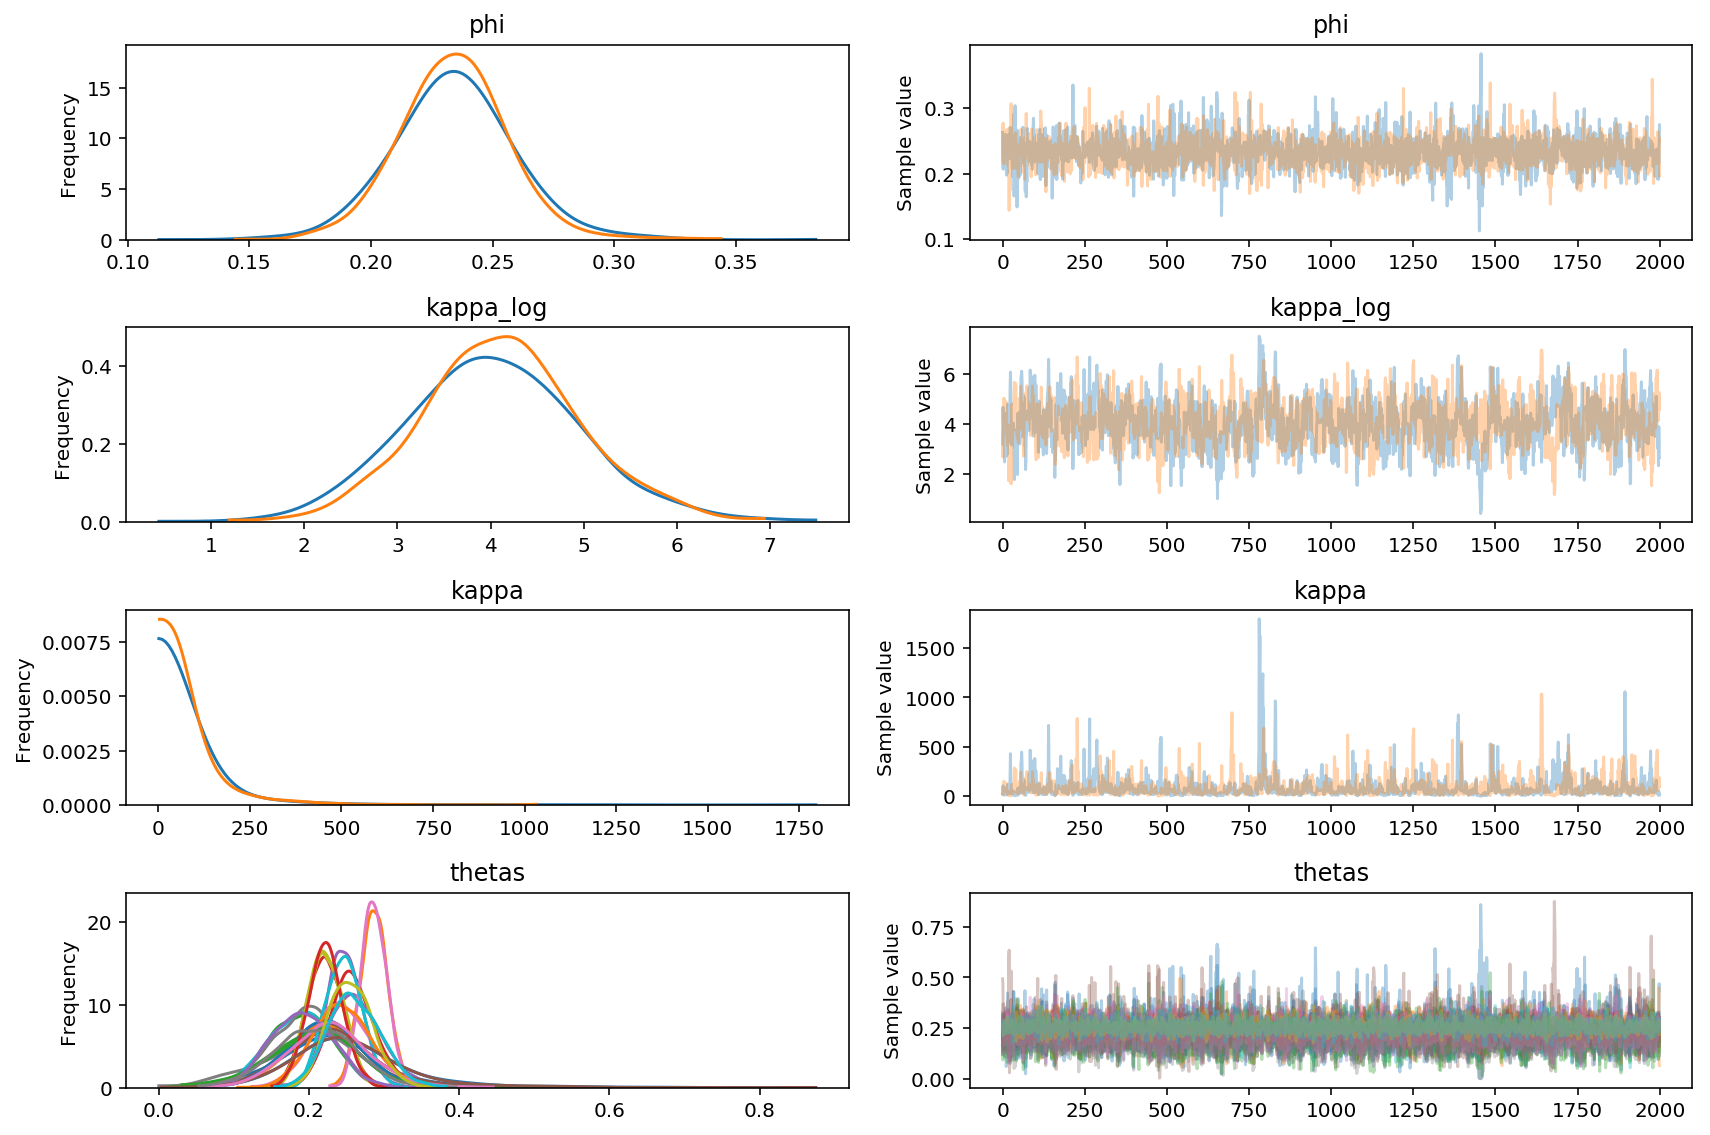

In [22]:
pm.traceplot(trace)

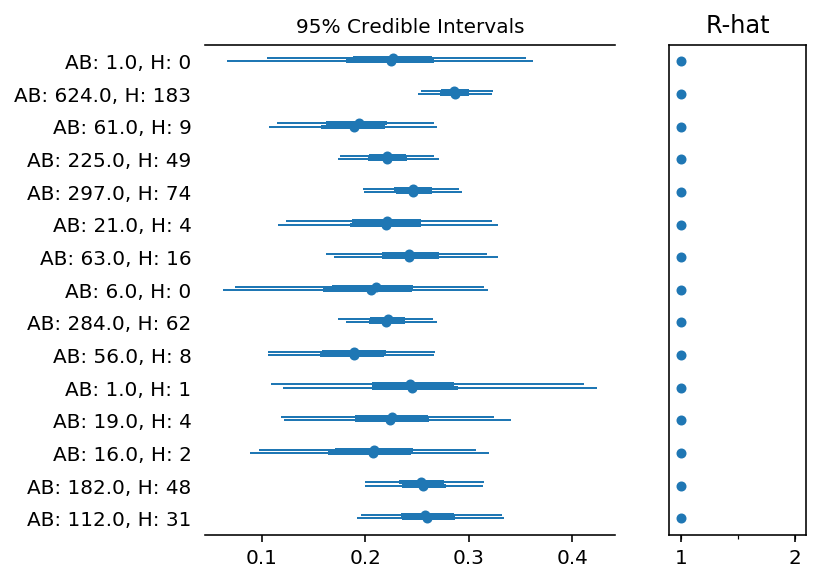

In [23]:
ylabels = "AB: " + df['AB'].astype(str) + ', H: ' + df['H'].astype('str')
pm.forestplot(trace, varnames=['thetas'], ylabels=ylabels)

With a hierarchical model, we make the assumption that our observations (or treatments that group our observations) are somehow related. Under this assumption, when we have a new sample for which we have very few observations, we are able to borrow power from the population to make inferences about the new sample. 

Depending on the scenario, this assumption can either be reasonable, thereby not necessitating much debate, or be considered a "strong assumption", thereby requiring strong justification. 

# Summary

- Hierarchical modelling assumes a "hierarchical structure" that governs relatedness between our observed samples.
- Under the assumption of hierarchical structure holding true, we will not get estimates that one may consider to be absurd (e.g. long-run batting probability estimated to be zero or one, on the basis onf few observations).